# **Ambiente**

In [1]:
#pip install geopandas shapely matplotlib numpy pandas -q

In [2]:
#pip install harmonica cmocean -q

In [3]:
#apt-get install -y gdal-bin python3-gdal
#gdalinfo --version

In [4]:
#pip install rasterio -q

In [5]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

from shapely.geometry import Polygon

import harmonica as hm
import xarray as xr
from scipy.interpolate import griddata

import cmocean

In [6]:
from shapely.geometry import shape, Polygon, mapping

from pyproj import Transformer, CRS

import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.crs import CRS

In [7]:
def plot_gdf_scatter(x, y, c, cmap, title, centered_to_zero = 'no'):
    try:
      import cmocean
    except:
      %pip install cmocean -q
      import cmocean
    import numpy as np
    import matplotlib.pyplot as plt

    if centered_to_zero == 'no':
      vmin = np.min(c)
      vmax = np.max(c)
    elif centered_to_zero == 'yes':
      vmin = -np.max(c)
      vmax = np.max(c)
    else:
      print('centered_to_zero must be yes or no')
      return

    fig, ax = plt.subplots(figsize=(8, 6))
    sc = ax.scatter(
        x, y,
        c=c,
        cmap=cmap,
        s=2,
        alpha=0.8,
        linewidth=0,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_xlabel("Easting")
    ax.set_ylabel("Northing")
    ax.set_title(title)
    ax.set_aspect("equal", adjustable="box")
    cbar = fig.colorbar(sc, ax=ax, shrink=0.7, pad=0.02)
    cbar.set_label(title)
    plt.grid(True, linewidth=0.3, alpha=0.5)
    plt.tight_layout()
    plt.show()

# **Arquivos de entrada**

Sistema de coordenadas personalizado - policônica com datum sirgas 2000 lido a partir de dados gerados no Oasis Montaj

In [8]:
from pyproj import CRS

# String do .prj
wkt_string = '''PROJCS["Polyconic_Brasil",GEOGCS["GCS_SIRGAS_2000",
DATUM["D_SIRGAS_2000",SPHEROID["GRS_1980",6378137,298.257222101]],
PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199432955]],
PROJECTION["Polyconic"],PARAMETER["False_Easting",5000000],
PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",-54],
PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]'''

# Criar o objeto CRS a partir do WKT
crs_projeto = CRS.from_wkt(wkt_string)

print(crs_projeto)

PROJCS["Polyconic_Brasil",GEOGCS["GCS_SIRGAS_2000",
DATUM["D_SIRGAS_2000",SPHEROID["GRS_1980",6378137,298.257222101]],
PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199432955]],
PROJECTION["Polyconic"],PARAMETER["False_Easting",5000000],
PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",-54],
PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]


**Upload dos dados preparados na Etapa 2**

In [9]:
grav_gdf_offshore = gpd.read_file("grav_fa_offshore.gpkg")

grav_gdf_offshore = grav_gdf_offshore.to_crs(crs_projeto)
print(grav_gdf_offshore.crs)
print(grav_gdf_offshore.head())

PROJCS["Polyconic_Brasil",GEOGCS["GCS_SIRGAS_2000",
DATUM["D_SIRGAS_2000",SPHEROID["GRS_1980",6378137,298.257222101]],
PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199432955]],
PROJECTION["Polyconic"],PARAMETER["False_Easting",5000000],
PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",-54],
PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]
    LATITUDE  LONGITUDE         FA  BAT                         geometry
0 -31.208333 -51.625000  18.532032 -3.9  POINT (5226310.605 6543497.034)
1 -31.208333 -51.608333  14.369975 -4.2  POINT (5227898.503 6543462.803)
2 -31.208333 -51.591667   9.570622 -4.5  POINT (5229486.395 6543428.334)
3 -31.208333 -51.575000   6.086368 -4.6  POINT (5231074.283 6543393.625)
4 -31.208333 -51.558333   5.576085 -4.9  POINT (5232662.165 6543358.677)


In [10]:
grav_gdf_onshore = gpd.read_file("grav_fa_onshore.gpkg")

grav_gdf_onshore = grav_gdf_onshore.to_crs(crs_projeto)
print(grav_gdf_onshore.crs)
print(grav_gdf_onshore.head())

PROJCS["Polyconic_Brasil",GEOGCS["GCS_SIRGAS_2000",
DATUM["D_SIRGAS_2000",SPHEROID["GRS_1980",6378137,298.257222101]],
PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199432955]],
PROJECTION["Polyconic"],PARAMETER["False_Easting",5000000],
PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",-54],
PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]
    LATITUDE  LONGITUDE   GRAV_OBS   ALT_ORTCO     FA_CORR         FA  \
0 -26.726082 -49.484579  978933.06  518.086182  159.049316  16.115110   
1 -26.733934 -49.478549  978933.21  522.671387  160.449524  17.097782   
2 -26.744365 -49.478098  978934.66  520.868408  159.898941  17.243218   
3 -26.752794 -49.473389  978937.82  517.515625  158.875076  18.769859   
4 -26.757917 -49.464726  978938.57  517.563477  158.889694  19.164027   

                          geometry  
0  POINT (5449164.322 7034759.678)  
1  POINT (5449732.972 7033866.688)  
2  POINT (5449736.738 7032707.276)  
3  POINT (5450171.613 7031754.912)  
4   POINT (54

In [11]:
# Concatenate the two GeoDataFrames
grav_gdf_all = pd.concat([grav_gdf_offshore, grav_gdf_onshore], ignore_index=True)

# Display the head of the combined GeoDataFrame and its length
print("Combined GeoDataFrame head:")
print(grav_gdf_all.head())
print("\nNumber of points in combined GeoDataFrame:", len(grav_gdf_all))

Combined GeoDataFrame head:
    LATITUDE  LONGITUDE         FA  BAT                         geometry  \
0 -31.208333 -51.625000  18.532032 -3.9  POINT (5226310.605 6543497.034)   
1 -31.208333 -51.608333  14.369975 -4.2  POINT (5227898.503 6543462.803)   
2 -31.208333 -51.591667   9.570622 -4.5  POINT (5229486.395 6543428.334)   
3 -31.208333 -51.575000   6.086368 -4.6  POINT (5231074.283 6543393.625)   
4 -31.208333 -51.558333   5.576085 -4.9  POINT (5232662.165 6543358.677)   

   GRAV_OBS  ALT_ORTCO  FA_CORR  
0       NaN        NaN      NaN  
1       NaN        NaN      NaN  
2       NaN        NaN      NaN  
3       NaN        NaN      NaN  
4       NaN        NaN      NaN  

Number of points in combined GeoDataFrame: 639577


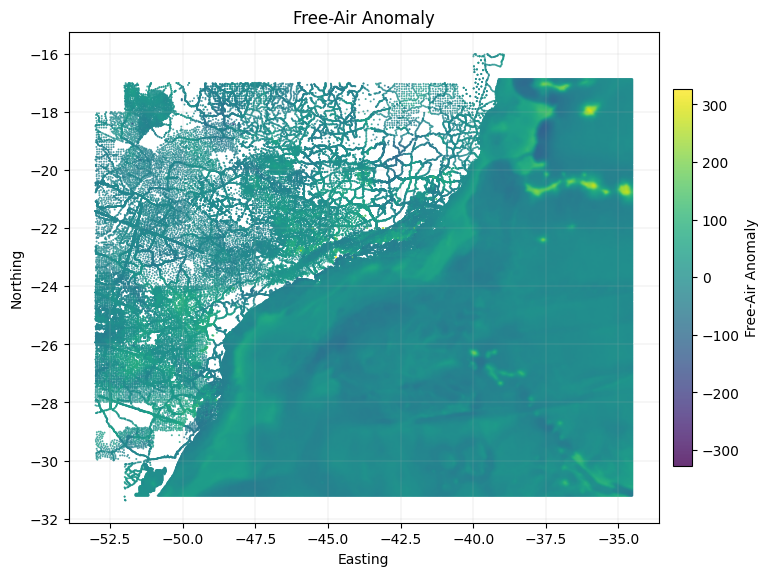

In [12]:
plot_gdf_scatter(grav_gdf_all.LONGITUDE, grav_gdf_all.LATITUDE, grav_gdf_all.FA, 'viridis', 'Free-Air Anomaly', 'yes')

# **2. Redução dos dados 2 - Bouguer**


## **2.1 Onshore**

### **Creating prisms layer**

#### Opening the Copernicus topography TIF

In [ ]:
with rasterio.open("ribeira_copernicus_mosaic.tif") as src:
    topo_array = src.read(1)  # matriz 2D de elevação
    crs = src.crs
    print(crs)

EPSG:4326


#### Reproject TIF

In [14]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

# CRS de destino (sua projeção policônica)
dst_crs = crs_projeto

# Abrir o TIF original (em WGS84 ou outro CRS geográfico)
with rasterio.open("ribeira_copernicus_mosaic.tif") as src:
    print("== TIF original ==")
    print("CRS:", src.crs)
    print("Bounds:", src.bounds)
    print("Shape (altura, largura):", src.height, src.width)
    
    # Calcular a transformação para o novo CRS
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )

    print("\n== TIF reprojetado (esperado) ==")
    print("Novo CRS:", dst_crs)
    print("Transform:", transform)
    print("Nova largura x altura:", width, height)

    # Criar novo metadado para o TIF reprojetado
    kwargs = src.meta.copy()
    kwargs.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height
    })

    # Criar e escrever o TIF reprojetado
    with rasterio.open("copernicus_polic.tif", "w", **kwargs) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear
        )

== TIF original ==
CRS: EPSG:4326
Bounds: BoundingBox(left=-53.00013888888889, bottom=-31.99986111111111, right=-38.00013888888889, top=-15.99986111111111)
Shape (altura, largura): 57600 54000

== TIF reprojetado (esperado) ==
Novo CRS: PROJCS["Polyconic_Brasil",GEOGCS["GCS_SIRGAS_2000",
DATUM["D_SIRGAS_2000",SPHEROID["GRS_1980",6378137,298.257222101]],
PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199432955]],
PROJECTION["Polyconic"],PARAMETER["False_Easting",5000000],
PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",-54],
PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]
Transform: | 29.72, 0.00, 5094478.81|
| 0.00,-29.72, 8230114.75|
| 0.00, 0.00, 1.00|
Nova largura x altura: 54386 63378


In [15]:
# Verifying properties of the reprojected TIF (local file)
with rasterio.open("copernicus_polic.tif") as reproj:
    dem_cop_data = reproj.read(1)
    print("\nTIF reprojetado aberto do arquivo")
    print("CRS:", reproj.crs)
    print("Bounds:", reproj.bounds)
    print("Shape (altura, largura):", reproj.height, reproj.width)
    extent = [reproj.bounds.left, reproj.bounds.right, reproj.bounds.bottom, reproj.bounds.top]



TIF reprojetado aberto do arquivo
CRS: EPSG:5880
Bounds: BoundingBox(left=5094478.813601828, bottom=6346516.761752969, right=6710834.01925588, top=8230114.7506461125)
Shape (altura, largura): 63378 54386


'#plt.figure(figsize=(10, 8))\n###### ⚠️ (!) TIME-CONSUMING STEP (!)\nplt.imshow(dem_cop_data, cmap=\'viridis\', extent=extent, origin=\'upper\')\nplt.colorbar(label="Altitude (m)")\nplt.title("Modelo Digital de Elevação - Copernicus")\nplt.xlabel("Easting (m)")\nplt.ylabel("Northing (m)")\nplt.grid(False)\nplt.show()'

In [16]:
with rasterio.open("copernicus_polic.tif") as src:
    dem_cop_data = src.read(1).astype(float)
    nodata = src.nodata
    # Extrair o transform
    transform = src.transform
    x_cop, y_cop = src.width, src.height
    # Criar vetores de coordenadas em metros
    xi_cop = transform.c + np.arange(x_cop) * transform.a  # easting
    yi_cop = transform.f + np.arange(y_cop) * transform.e  # northing
    if transform.e < 0:
        yi_cop = yi_cop[::-1]
        dem_cop_data = np.flipud(dem_cop_data)

# handle nodata values 
dem_cop_data = np.where(dem_cop_data == nodata, 0, dem_cop_data).astype(float)

#### Prisms layer configuration

In [ ]:
# dem_cop_data --> Copernicus full data

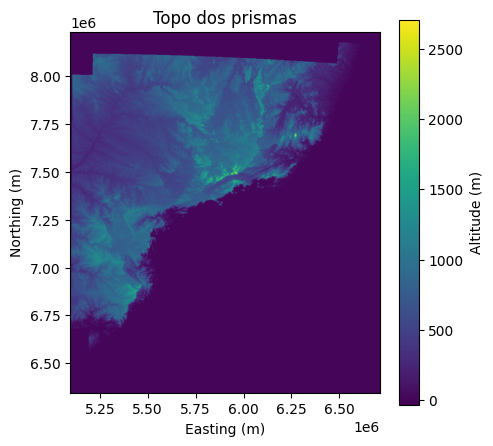

In [ ]:
from scipy.interpolate import RegularGridInterpolator, griddata

x_obs = grav_gdf_onshore.geometry.x.values
y_obs = grav_gdf_onshore.geometry.y.values
z_obs = grav_gdf_onshore["ALT_ORTCO"].values

target_resolution = 2000  # resolução desejada para a malha
delta_max = 50  # tolerância máxima para substituição dos valores de topo

# ===== DADOS DO DEM COPERNICUS =====
with rasterio.open("copernicus_polic.tif") as src:
    dem_cop_data = src.read(1).astype(float)
    nodata = src.nodata
    transform = src.transform
    x_cop, y_cop = src.width, src.height

# Converter nodata para zero
dem_cop_data = np.where(dem_cop_data == nodata, 0, dem_cop_data)

# Gerar vetores de coordenadas com base no transform
xi_cop = transform.c + np.arange(x_cop) * transform.a
yi_cop = transform.f + np.arange(y_cop) * transform.e  # normalmente e < 0

# ===== GERAR MALHA DE MENOR RESOLUCAO =====
x_obs = grav_gdf_onshore.geometry.x.values
y_obs = grav_gdf_onshore.geometry.y.values

x_min = min(x_obs.min(), xi_cop.min())
x_max = max(x_obs.max(), xi_cop.max())
y_min = min(y_obs.min(), yi_cop.min())
y_max = max(y_obs.max(), yi_cop.max())

xi = np.arange(x_min, x_max + target_resolution, target_resolution)
yi = np.arange(y_min, y_max + target_resolution, target_resolution)
grid_x, grid_y = np.meshgrid(xi, yi)
assert (x_obs.min() >= xi.min()) and (x_obs.max() <= xi.max()), "xi não cobre todos os pontos"
assert (y_obs.min() >= yi.min()) and (y_obs.max() <= yi.max()), "yi não cobre todos os pontos"


# ===== Interpolacao do DEM em malha de menor resolucao =====
# Interpolador a partir do DEM completo (invertendo eixo Y)
# para gerar uam layer de prismas próximos da topografia, mesmo
# onde há gaps nos dados de observacao grav

interp_dem = RegularGridInterpolator(
    (yi_cop[::-1], xi_cop), 
    np.flipud(dem_cop_data), 
    bounds_error=False, 
    fill_value=np.nan
)

# Interpolar para fazer o topo dos prismas
surface = interp_dem((grid_y, grid_x))
surface = np.where(np.isnan(surface), 0, surface) # NaN --> zero 

# ===== Substituicao com ALT_ORTCO =====
# Esta etapa substitui o valor do topo do prisma pelo valor de altitude
# no ponto de observação, contanto que a diferença seja até 50 m

x_obs = grav_gdf_onshore.geometry.x.values
y_obs = grav_gdf_onshore.geometry.y.values
z_obs = grav_gdf_onshore.ALT_ORTCO.values
z_interp = interp_dem((y_obs, x_obs))

# Registrar substituições válidas
substituidos = []

for xo, yo, zo, zi in zip(x_obs, y_obs, z_obs, z_interp):
    if np.abs(zo - zi) <= delta_max:
        ix = np.argmin(np.abs(xi - xo))
        iy = np.argmin(np.abs(yi - yo))
        surface[iy, ix] = zo
        substituidos.append({
            "x": xo,
            "y": yo,
            "valor_dem_original": zi,
            "valor_substituido": zo,
            "diferenca": zo - zi,
            "ix_prisma": ix,
            "iy_prisma": iy
        })

# Exportar substituições
df_dem_corr = pd.DataFrame(substituidos)
df_dem_corr.to_csv("dem_corr.csv", index=False)

# Plot para conferência dos prismas
plt.figure(figsize=(5, 5))
plt.imshow(surface, origin="lower", extent=(xi.min(), xi.max(), yi.min(), yi.max()))
plt.title(f"Top surface of prisms layer (resolution of {target_resolution})")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="Altitude (m)")
plt.show()



In [ ]:
# Geometric Parameters

top_surface = surface

base_reference = 0

obs_coordinates = (grav_gdf_onshore.geometry.x, grav_gdf_onshore.geometry.y, grav_gdf_onshore.ALT_ORTCO.values) # NO MAR Z=0!!!

#prism_centers = (yi, xi)  # (northing, easting)


### **Gravity effect**

##### Density

In [ ]:
# Density Parameters
rock_density, cover_density = 2670, 0
density_contrast_map = (rock_density - cover_density) * np.ones_like(surface)

topo_prisms = hm.prism_layer(
    coordinates = (xi, yi),
    surface = top_surface,
    reference = base_reference,
    properties = {"density": density_contrast_map}
)

##### Gravity calculation with chunks

In [27]:
import dask
import dask.array as da
from dask.diagnostics import ProgressBar

chunk_size = 1000   # points

# Arrays
x_obs = np.asarray(obs_coordinates[0])
y_obs = np.asarray(obs_coordinates[1])
z_obs = np.asarray(obs_coordinates[2])

n_obs = len(x_obs)

# Função para calcular g_z em um chunk
def compute_chunk(start_idx, end_idx):
    x_chunk = x_obs[start_idx:end_idx]
    y_chunk = y_obs[start_idx:end_idx]
    z_chunk = z_obs[start_idx:end_idx]
    return topo_prisms.prism_layer.gravity((x_chunk, y_chunk, z_chunk), field="g_z")

# Criar tarefas Dask
tasks = []
for start in range(0, n_obs, chunk_size):
    end = min(start + chunk_size, n_obs)
    task = dask.delayed(compute_chunk)(start, end)
    tasks.append(task)

# Concatenar os chunks em um único array
final_result = dask.delayed(np.concatenate)(tasks)

with ProgressBar():
    grav_effect = final_result.compute()

[########################################] | 100% Completed | 27m 41s


##### Classical calculation

In [ ]:
# Calc
# result = topo_prisms.prism_layer.gravity(obs_coordinates, field="g_z")

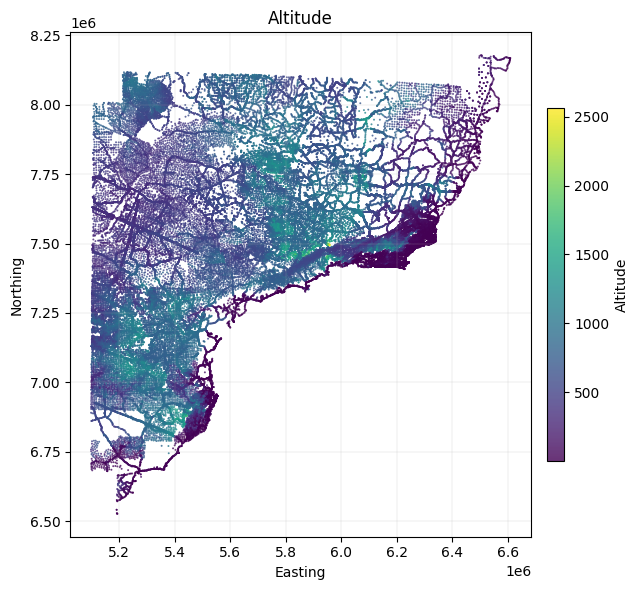

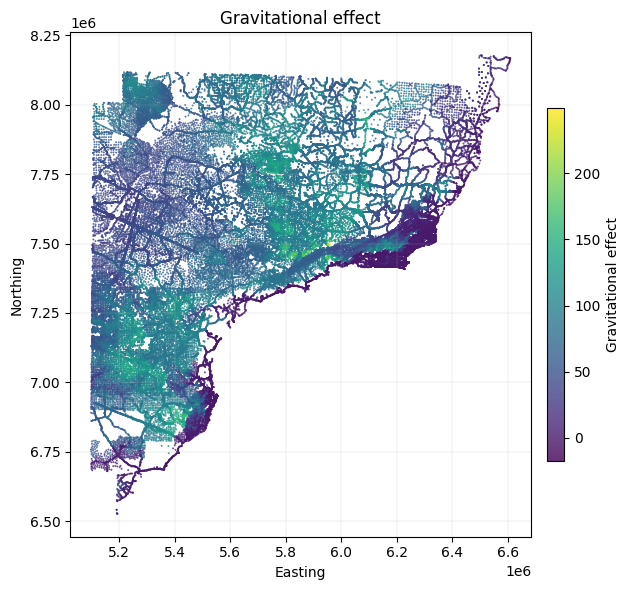

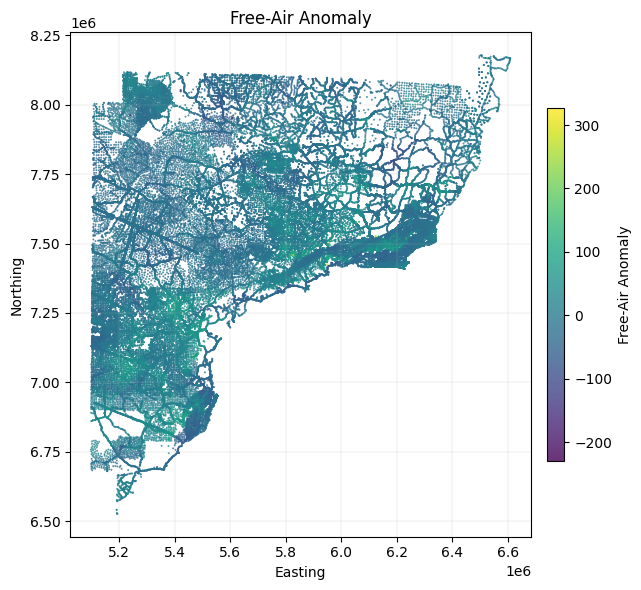

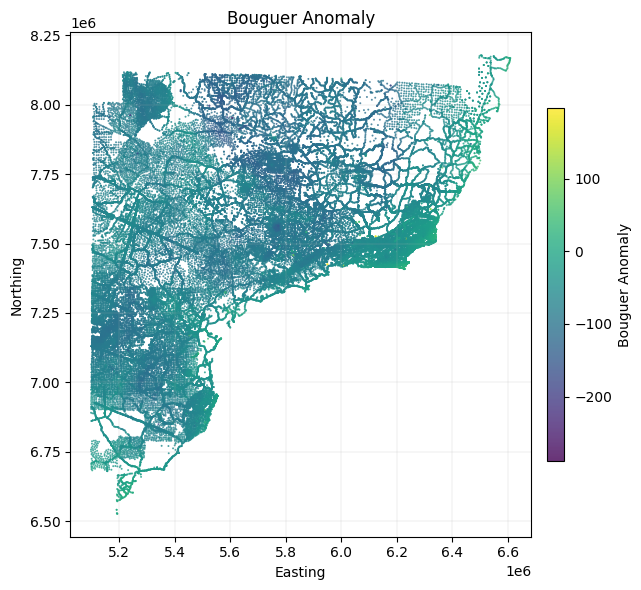

In [29]:
grav_gdf_onshore[f'GRAV_EFFECT_d{rock_density}'] = grav_effect
grav_gdf_onshore[f'BOUG_d{rock_density}'] = grav_gdf_onshore['FA'] - grav_effect

plot_gdf_scatter(grav_gdf_onshore.geometry.x, grav_gdf_onshore.geometry.y, grav_gdf_onshore.ALT_ORTCO, 'viridis', 'Altitude')
plot_gdf_scatter(grav_gdf_onshore.geometry.x, grav_gdf_onshore.geometry.y, grav_gdf_onshore[f'GRAV_EFFECT_d{rock_density}'].values, 'viridis', 'Gravitational effect')
plot_gdf_scatter(grav_gdf_onshore.geometry.x, grav_gdf_onshore.geometry.y, grav_gdf_onshore.FA, 'viridis', 'Free-Air Anomaly')
plot_gdf_scatter(grav_gdf_onshore.geometry.x, grav_gdf_onshore.geometry.y, grav_gdf_onshore[f'BOUG_d{rock_density}'].values, 'viridis', 'Bouguer Anomaly')

In [ ]:
# Save files

# CSV file

grav_effect = pd.DataFrame({
    'X': grav_gdf_onshore.geometry.x,
    'Y': grav_gdf_onshore.geometry.y,
    f'BOUG_d{rock_density}': grav_gdf_onshore[f'BOUG_d{rock_density}'],
    'FA': grav_gdf_onshore.FA,
    'ALT': grav_gdf_onshore.ALT_ORTCO,
})

grav_effect.to_csv(str(f'grav_onshore_d{rock_density}_res{target_resolution}_versao-prismas.csv'), index=False)

# GPKG

grav_gdf_onshore.to_file(str(f'grav_onshore_d{rock_density}_res{target_resolution}_versao-prismas.gpkg'), driver='GPKG')


## **2.2 Offshore**

#### Open bathymetric data from TIF

In [52]:
with rasterio.open("bat_win.tif") as src:
    dados = src.read(1)
    print(src.crs)

EPSG:5880


#### Reproject TIF (optional)

In [ ]:
'''import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

# CRS de destino
dst_crs = crs_projeto

# Abrir o TIF original (em WGS84)
with rasterio.open("bat_rasterized_geog_wgs84.tif") as src:
    print("== TIF original ==")
    print("CRS:", src.crs)
    print("Bounds:", src.bounds)
    print("Shape (altura, largura):", src.height, src.width)
    
    # Calcular a transformação para o novo CRS
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )

    print("\n== TIF reprojetado (esperado) ==")
    print("Novo CRS:", dst_crs)
    print("Transform:", transform)
    print("Nova largura x altura:", width, height)

    # Criar novo metadado para o TIF reprojetado
    kwargs = src.meta.copy()
    kwargs.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height
    })

    # Criar e escrever o TIF reprojetado
    with rasterio.open("bat_polic.tif", "w", **kwargs) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear
        )'''

== TIF original ==
CRS: EPSG:4326
Bounds: BoundingBox(left=-50.45305038640887, bottom=-29.989961686715674, right=-35.71515159918174, top=-18.064711539733054)
Shape (altura, largura): 1255 1551

== TIF reprojetado (esperado) ==
Novo CRS: PROJCS["Polyconic_Brasil",GEOGCS["GCS_SIRGAS_2000",
DATUM["D_SIRGAS_2000",SPHEROID["GRS_1980",6378137,298.257222101]],
PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199432955]],
PROJECTION["Polyconic"],PARAMETER["False_Easting",5000000],
PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",-54],
PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]
Transform: | 1006.59, 0.00, 5342211.80|
| 0.00,-1006.59, 7998251.69|
| 0.00, 0.00, 1.00|
Nova largura x altura: 1580 1448


#### Prisms layer configuration

CRS: EPSG:5880


C:\Users\Luizemara\AppData\Local\Temp\ipykernel_7760\1154988464.py:50: UserWarning: Aviso: xi não cobre todos os pontos de observação (x).
  warnings.warn("Aviso: xi não cobre todos os pontos de observação (x).")
C:\Users\Luizemara\AppData\Local\Temp\ipykernel_7760\1154988464.py:53: UserWarning: Aviso: yi não cobre todos os pontos de observação (y).
  warnings.warn("Aviso: yi não cobre todos os pontos de observação (y).")


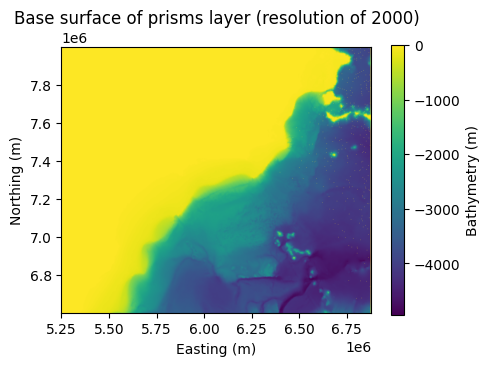

In [ ]:
from scipy.interpolate import RegularGridInterpolator, griddata

x_obs = grav_gdf_offshore.geometry.x.values
y_obs = grav_gdf_offshore.geometry.y.values
z_obs = grav_gdf_offshore["BAT"].values

target_resolution = 2000  # resolução desejada para a malha
delta_max = 50  # tolerância máxima para substituição dos valores de topo

# ===== DADOS DEM LEPLAC =====
with rasterio.open("bat_win.tif") as src:
    dem_bat = src.read(1).astype(float)
    print("CRS:", src.crs)
    transform = src.transform # Affine(a, b, c,    d, e, f)
    nodata = src.nodata
    x_bat, y_bat = src.width, src.height
    # Criar vetores de coordenadas em metros
    xi_bat = transform.c + np.arange(x_bat) * transform.a
    yi_bat = transform.f + np.arange(y_bat) * transform.e  # normalmente eh < 0
    if transform.e < 0:
        yi_bat = yi_bat[::-1]
        dem_bat = np.flipud(dem_bat)

# handle nodata values 
#dem_bat = np.where(dem_bat == nodata, 0, dem_bat).astype(float)


# ===== GERAR MALHA DA RESOLUCAO ESCOLHIDA =====
x_obs = grav_gdf_offshore.geometry.x.values
y_obs = grav_gdf_offshore.geometry.y.values

#x_min = min(x_obs.min(), xi_bat.min())
#x_max = max(x_obs.max(), xi_bat.max())
#y_min = min(y_obs.min(), yi_bat.min())
#y_max = max(y_obs.max(), yi_bat.max())
x_min = xi_bat.min()
x_max = xi_bat.max()
y_min = yi_bat.min()
y_max = yi_bat.max()

xi = np.arange(x_min, x_max + target_resolution, target_resolution)
yi = np.arange(y_min, y_max + target_resolution, target_resolution)
grid_x, grid_y = np.meshgrid(xi, yi)

#assert (x_obs.min() >= xi.min()) and (x_obs.max() <= xi.max()), "xi não cobre todos os pontos"
#assert (y_obs.min() >= yi.min()) and (y_obs.max() <= yi.max()), "yi não cobre todos os pontos"
import warnings

if (x_obs.min() < xi.min()) or (x_obs.max() > xi.max()):
    warnings.warn("Aviso: xi não cobre todos os pontos de observação (x).")

if (y_obs.min() < yi.min()) or (y_obs.max() > yi.max()):
    warnings.warn("Aviso: yi não cobre todos os pontos de observação (y).")


# ===== Interpolacao do DEM em malha de menor resolucao =====
# Interpolador a partir do DEM completo (invertendo eixo Y)

interp_dem = RegularGridInterpolator(
    (yi_bat[::-1], xi_bat), 
    np.flipud(dem_bat), 
    bounds_error=False, 
    fill_value=np.nan
)

# Interpolar para fazer o topo dos prismas
surface = interp_dem((grid_y, grid_x))
surface = np.where(np.isnan(surface), 0, surface) # NaN --> zero 

# ===== Substituicao com ALT_ORTCO =====
# Esta etapa substitui o valor do topo do prisma pelo valor de altitude
# no ponto de observação, contanto que a diferença seja até 50 m

z_interp = interp_dem((y_obs, x_obs))

# Registrar substituições válidas
substituidos = []

for xo, yo, zo, zi in zip(x_obs, y_obs, z_obs, z_interp):
    if np.abs(zo - zi) <= delta_max:
        ix = np.argmin(np.abs(xi - xo))
        iy = np.argmin(np.abs(yi - yo))
        surface[iy, ix] = zo  #
        substituidos.append({
            "x": xo,
            "y": yo,
            "valor_dem_original": zi,
            "valor_substituido": zo,
            "diferenca": zo - zi,
            "ix_prisma": ix,
            "iy_prisma": iy
        })

# Exportar substituições
df_dem_bat_corr = pd.DataFrame(substituidos)
df_dem_bat_corr.to_csv("dem_bat_corr.csv", index=False)

# Plot para conferência dos prismas
plt.figure(figsize=(5, 5))
plt.imshow(surface, origin="lower", extent=(xi.min(), xi.max(), yi.min(), yi.max()))
plt.scatter(grav_gdf_offshore.geometry.x, grav_gdf_offshore.geometry.y)
plt.title(f"Base surface of prisms layer (resolution of {target_resolution})")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="Bathymetry (m)", shrink=0.7)
plt.show()



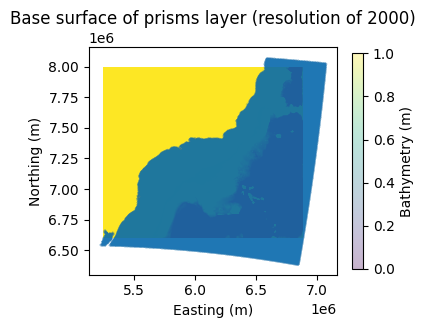

In [69]:
# Plot para conferência dos prismas
plt.figure(figsize=(4, 4))
plt.imshow(surface, origin="lower", extent=(xi.min(), xi.max(), yi.min(), yi.max()))
plt.scatter(grav_gdf_offshore.geometry.x, grav_gdf_offshore.geometry.y, s=0.01, alpha=0.3)
plt.title(f"Base surface of prisms layer (resolution of {target_resolution})")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="Bathymetry (m)", shrink=0.7)
plt.show()

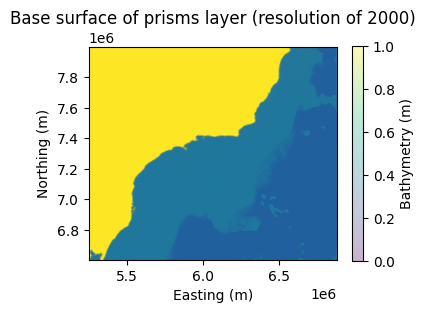

In [73]:
# Recortar o GeoDataFrame

with rasterio.open("bat_win.tif") as src:
    bounds = src.bounds

minx, miny, maxx, maxy = bounds.left, bounds.bottom, bounds.right, bounds.top



grav_gdf_offshore = grav_gdf_offshore[
    (grav_gdf_offshore.geometry.x >= xi.min()) & (grav_gdf_offshore.geometry.x <= xi.max()) &
    (grav_gdf_offshore.geometry.y >= yi.min()) & (grav_gdf_offshore.geometry.y <= yi.max())
].copy()

# Plot para conferência dos prismas
plt.figure(figsize=(4, 4))
plt.imshow(surface, origin="lower", extent=(xi.min(), xi.max(), yi.min(), yi.max()))
plt.scatter(grav_gdf_offshore.geometry.x, grav_gdf_offshore.geometry.y, s=0.01, alpha=0.3)
plt.title(f"Base surface of prisms layer (resolution of {target_resolution})")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="Bathymetry (m)", shrink=0.7)
plt.show()

In [ ]:
# Geometric Parameters

top_surface = np.zeros_like(surface) # zero for offshore data

base_reference = surface

obs_coordinates = (grav_gdf_offshore.geometry.x, grav_gdf_offshore.geometry.y, np.zeros_like(grav_gdf_offshore.FA.values)) # zero for offshore data


#prism_centers = (yi, xi)  # (northing, easting)


#### Density

In [82]:
# Density Parameters
rock_density, cover_density = 2670, 1030
density_contrast_map = (rock_density - cover_density) * np.ones_like(surface)

topo_prisms = hm.prism_layer(
    coordinates = (xi, yi),
    surface = top_surface,
    reference = base_reference,
    properties = {"density": density_contrast_map}
)

#### Gravity calculation with chunks

In [83]:
import dask
import dask.array as da
from dask.diagnostics import ProgressBar

chunk_size = 1000   # points

# Arrays
x_obs = np.asarray(obs_coordinates[0])
y_obs = np.asarray(obs_coordinates[1])
z_obs = np.asarray(obs_coordinates[2])

n_obs = len(x_obs)

# Função para calcular g_z em um chunk
def compute_chunk(start_idx, end_idx):
    x_chunk = x_obs[start_idx:end_idx]
    y_chunk = y_obs[start_idx:end_idx]
    z_chunk = z_obs[start_idx:end_idx]
    return topo_prisms.prism_layer.gravity((x_chunk, y_chunk, z_chunk), field="g_z")

# Criar tarefas Dask
tasks = []
for start in range(0, n_obs, chunk_size):
    end = min(start + chunk_size, n_obs)
    task = dask.delayed(compute_chunk)(start, end)
    tasks.append(task)

# Concatenar os chunks em um único array
final_result = dask.delayed(np.concatenate)(tasks)

with ProgressBar():
    grav_effect = final_result.compute()

[########################################] | 100% Completed | 107m 26s


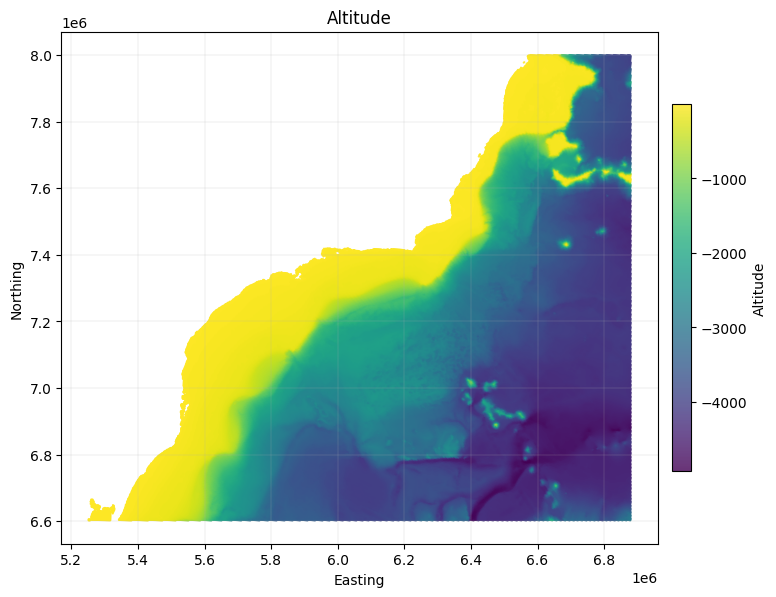

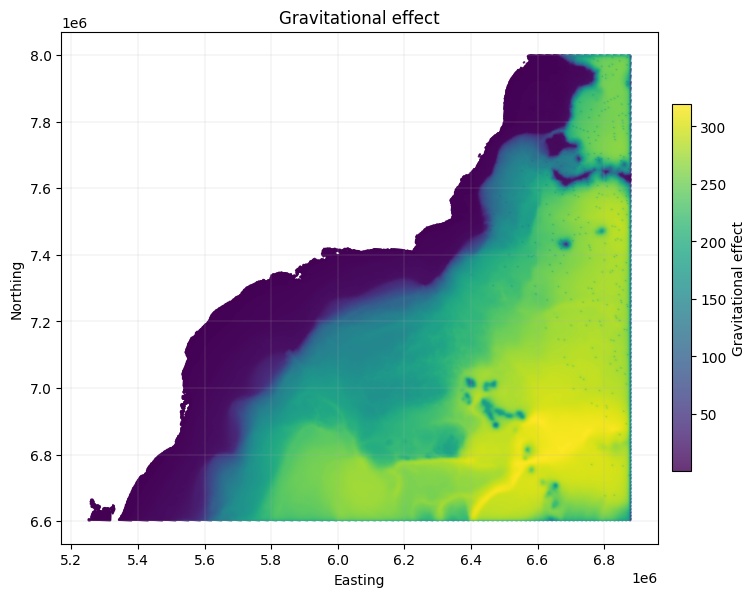

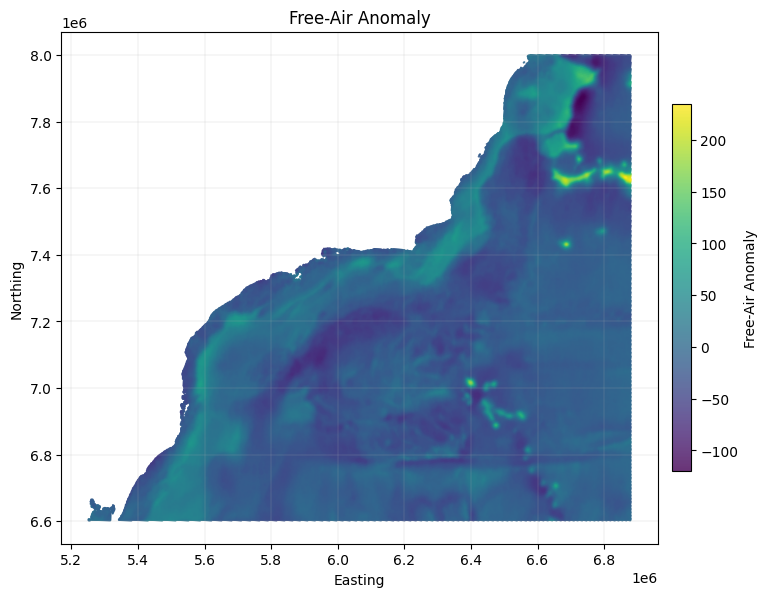

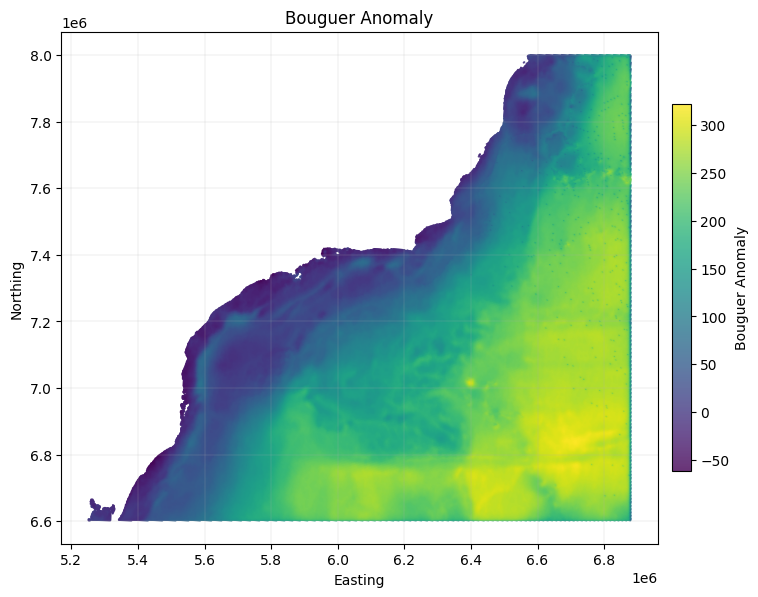

In [86]:
grav_gdf_offshore[f'GRAV_EFFECT_d{rock_density}'] = grav_effect
grav_gdf_offshore[f'BOUG_d{rock_density}'] = grav_gdf_offshore['FA'] + grav_effect

plot_gdf_scatter(grav_gdf_offshore.geometry.x, grav_gdf_offshore.geometry.y, grav_gdf_offshore.BAT, 'viridis', 'Altitude')
plot_gdf_scatter(grav_gdf_offshore.geometry.x, grav_gdf_offshore.geometry.y, grav_gdf_offshore[f'GRAV_EFFECT_d{rock_density}'].values, 'viridis', 'Gravitational effect')
plot_gdf_scatter(grav_gdf_offshore.geometry.x, grav_gdf_offshore.geometry.y, grav_gdf_offshore.FA, 'viridis', 'Free-Air Anomaly')
plot_gdf_scatter(grav_gdf_offshore.geometry.x, grav_gdf_offshore.geometry.y, grav_gdf_offshore[f'BOUG_d{rock_density}'].values, 'viridis', 'Bouguer Anomaly')

In [87]:
# Save files

# CSV file

grav_effect = pd.DataFrame({
    'X': grav_gdf_offshore.geometry.x,
    'Y': grav_gdf_offshore.geometry.y,
    f'BOUG_d{rock_density}': grav_gdf_offshore[f'BOUG_d{rock_density}'],
    'FA': grav_gdf_offshore.FA,
    'ALT': grav_gdf_offshore.BAT,
})

grav_effect.to_csv(str(f'grav_onshore_d{rock_density}_res{target_resolution}_versao-prismas.csv'), index=False)

# GPKG

grav_gdf_offshore.to_file(str(f'grav_onshore_d{rock_density}_res{target_resolution}_versao-prismas.gpkg'), driver='GPKG')


# Código anterior (desconsiderar por agora!)

Spatial resolution

In [56]:
target_resolution = 2000   # m

x_min = grav_gdf_offshore.geometry.x.min()
x_max = grav_gdf_offshore.geometry.x.max()
y_min = grav_gdf_offshore.geometry.y.min()
y_max = grav_gdf_offshore.geometry.y.max()

width = x_max - x_min
height = y_max - y_min

print(f"Dimensions of grav data in meters:")
print(f"Easting (x) from {x_min:.2f} m to {x_max:.2f} m (Width: {width:.2f} m)")
print(f"Northing (y) from {y_min:.2f} m to {y_max:.2f} m (Height: {height:.2f} m)")

nx = round(width/target_resolution)
print(nx)
print (nx*target_resolution)

ny = round(height/target_resolution)
print(ny)
print (ny*target_resolution)

Dimensions of grav data in meters:
Easting (x) from 5226310.61 m to 7071815.89 m (Width: 1845505.28 m)
Northing (y) from 6382918.80 m to 8073828.59 m (Height: 1690909.79 m)
923
1846000
845
1690000


In [ ]:
x = grav_gdf_offshore.geometry.x.values
y = grav_gdf_offshore.geometry.y.values
bat = grav_gdf_offshore["BAT"].values

# Grid resolution
ncols, nrows = nx, ny
xi = np.linspace(x.min(), x.max(), ncols)
yi = np.linspace(y.min(), y.max(), nrows)
grid_x, grid_y = np.meshgrid(xi, yi)

grid_z = griddata((x, y), bat, (grid_x, grid_y), method="linear")
grid_z[np.isnan(grid_z)] = 0

# Parameters
#surface = grid_z
surface = np.zeros_like(grid_z)

density = 1640 * np.ones_like(grid_z)

reference = grid_z

obs_coordinates = (
    grav_gdf_offshore.geometry.x.values, grav_gdf_offshore.geometry.y.values,
    np.zeros_like(grav_gdf_offshore["BAT"].values) # zero for offshore data
)

prism_centers = (xi, yi)  # (northing, easting)

topo_prisms = hm.prism_layer(
    coordinates = (xi, yi),
    surface = surface,
    reference = reference,
    properties = {"density": density}
)

result_1640 = topo_prisms.prism_layer.gravity(obs_coordinates, field="g_z")


In [ ]:
grav_gdf_offshore['GRAV_EFFECT_d2670'] = result_1640
grav_gdf_offshore['BOUG_d2670'] = grav_gdf_offshore['FA'] + result_1640

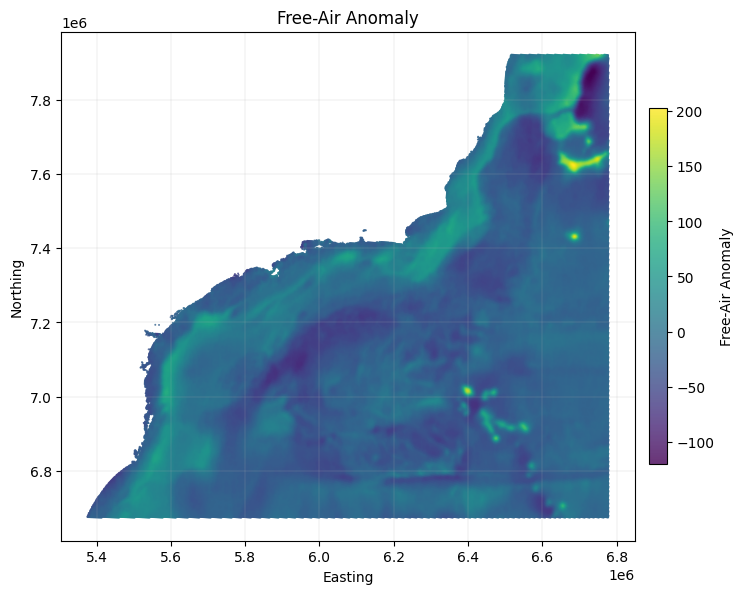

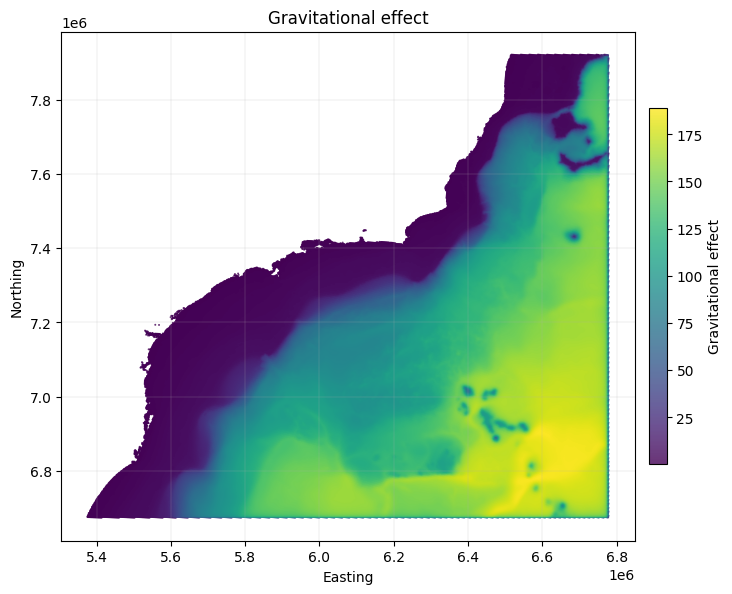

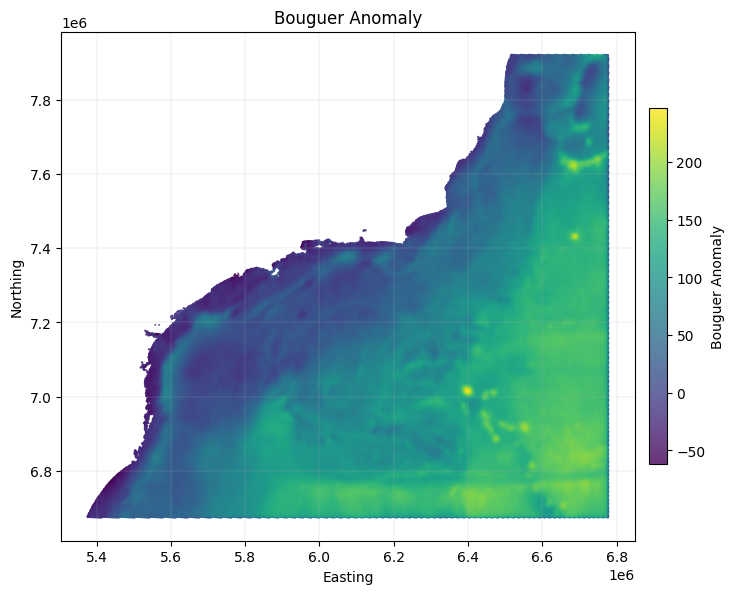

In [ ]:
plot_gdf_scatter(grav_gdf_offshore.geometry.x, grav_gdf_offshore.geometry.y, grav_gdf_offshore.FA, 'viridis', 'Free-Air Anomaly')
plot_gdf_scatter(grav_gdf_offshore.geometry.x, grav_gdf_offshore.geometry.y, grav_gdf_offshore.GRAV_EFFECT_d2670, 'viridis', 'Gravitational effect')
plot_gdf_scatter(grav_gdf_offshore.geometry.x, grav_gdf_offshore.geometry.y, grav_gdf_offshore.BOUG_d2670, 'viridis', 'Bouguer Anomaly')

In [ ]:
# Save the results

# CSV file

grav_effect = pd.DataFrame({
    'X': grav_gdf_offshore.geometry.x,
    'Y': grav_gdf_offshore.geometry.y,
    'BOUG_d2670': grav_gdf_offshore.BOUG_d2670,
    'FA': grav_gdf_offshore.FA,
    'ALT': grav_gdf_offshore.ALT_ORTCO,
})

grav_effect.to_csv('grav_offshore_d2670_res2000m.csv', index=False)

# GPKG

grav_gdf_offshore.to_file('grav_offshore_d2670_res2000m.gpkg', driver='GPKG')

## **2.3 Whole area**

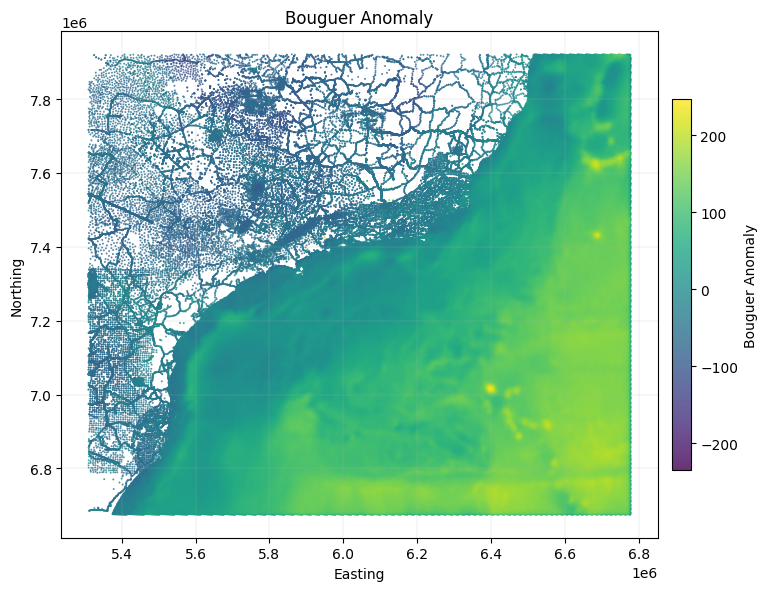

In [ ]:
grav_gdf_all = pd.concat([grav_gdf_offshore, grav_gdf_onshore], ignore_index=True)
plot_gdf_scatter(grav_gdf_all.geometry.x, grav_gdf_all.geometry.y, grav_gdf_all.BOUG_d2670, 'viridis', 'Bouguer Anomaly')

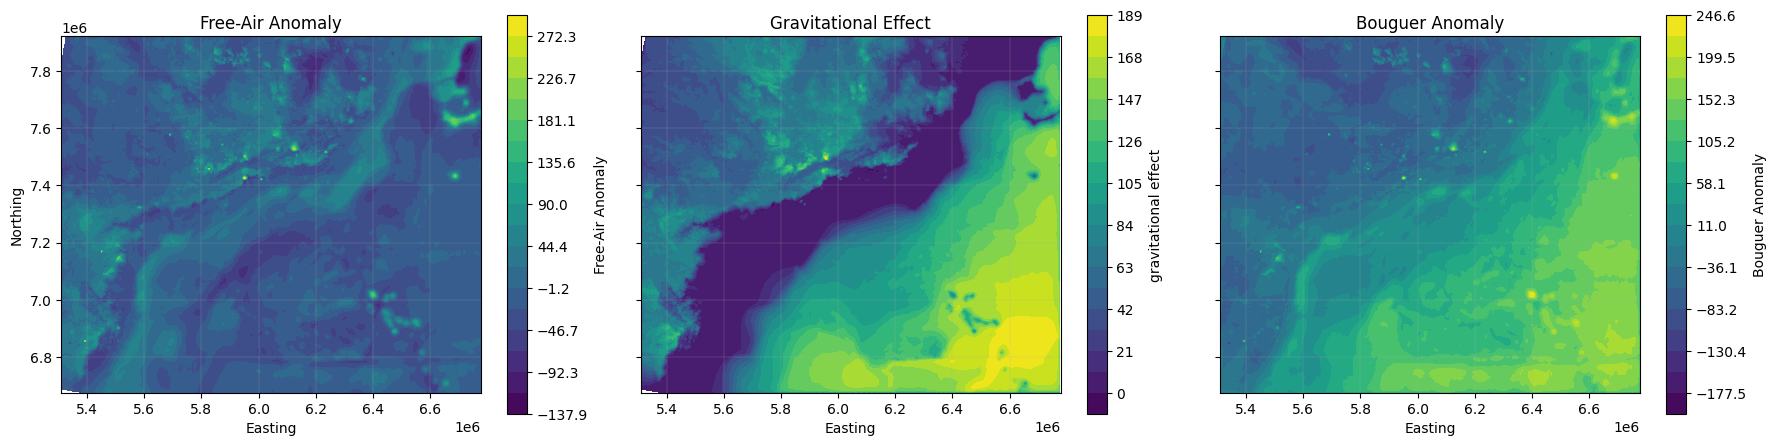

In [ ]:
# Grid Bouguer
x = grav_gdf_all.geometry.x.values
y = grav_gdf_all.geometry.y.values
boug = grav_gdf_all["BOUG_d2670"].values

ncols, nrows = nx, ny
xi = np.linspace(x.min(), x.max(), ncols)
yi = np.linspace(y.min(), y.max(), nrows)
grid_x, grid_y = np.meshgrid(xi, yi)

gridded_bouguer = griddata((x, y), boug, (grid_x, grid_y), method="linear")
gridded_bouguer[np.isnan(gridded_bouguer)] = 0

# Grid FA
gridded_fa = griddata((x, y), grav_gdf_all.FA.values, (grid_x, grid_y), method="linear")

# Grid gravitational effect
gridded_effect = griddata((x, y), grav_gdf_all.GRAV_EFFECT_d2000.values, (grid_x, grid_y), method="linear")


fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

contour_levels_fa = np.linspace(np.nanmin(gridded_fa), np.nanmax(gridded_fa), 20)
im1 = axes[0].contourf(grid_x, grid_y, gridded_fa, levels=contour_levels_fa, cmap='viridis')
fig.colorbar(im1, ax=axes[0], label='Free-Air Anomaly', shrink=0.7)
axes[0].set_xlabel("Easting")
axes[0].set_ylabel("Northing")
axes[0].set_title("Free-Air Anomaly")
axes[0].set_aspect("equal", adjustable="box")
axes[0].grid(True, linewidth=0.3, alpha=0.5)

contour_levels_effect = np.linspace(np.nanmin(gridded_effect), np.nanmax(gridded_effect), 20)
im2 = axes[1].contourf(grid_x, grid_y, gridded_effect, levels=contour_levels_effect, cmap='viridis')
fig.colorbar(im2, ax=axes[1], label='gravitational effect', shrink=0.7)
axes[1].set_xlabel("Easting")
# axes[1].set_ylabel("Northing")
axes[1].set_title("Gravitational Effect")
axes[1].set_aspect("equal", adjustable="box")
axes[1].grid(True, linewidth=0.3, alpha=0.5)

contour_levels_bouguer = np.linspace(np.nanmin(gridded_bouguer), np.nanmax(gridded_bouguer), 20)
im3 = axes[2].contourf(grid_x, grid_y, gridded_bouguer, levels=contour_levels_bouguer, cmap='viridis')
fig.colorbar(im3, ax=axes[2], label='Bouguer Anomaly', shrink=0.7)
axes[2].set_xlabel("Easting")
# axes[2].set_ylabel("Northing")
axes[2].set_title("Bouguer Anomaly")
axes[2].set_aspect("equal", adjustable="box")
axes[2].grid(True, linewidth=0.3, alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
grav_gdf_all.head()

LATITUDE  LONGITUDE         FA        BAT                         geometry  \
0   -29.975 -50.108333 -33.415165  -9.249272  POINT (5375514.437 6676285.656)   
1   -29.975 -50.091667 -29.462889 -13.559231  POINT (5377122.015 6676230.964)   
2   -29.975 -50.075000 -24.403582 -16.029474  POINT (5378729.584 6676176.038)   
3   -29.975 -50.058333 -19.615973 -21.713118  POINT (5380337.146 6676120.879)   
4   -29.975 -50.041667 -16.353775 -23.119534  POINT (5381944.699 6676065.486)   

   GRAV_EFFECT_d2000  BOUG_d2000  GRAV_OBS  ALT_ORTCO  FA_CORR  
0           0.046096  -33.369069       NaN        NaN      NaN  
1           0.615080  -28.847809       NaN        NaN      NaN  
2           0.758357  -23.645224       NaN        NaN      NaN  
3           0.764567  -18.851405       NaN        NaN      NaN  
4           0.956631  -15.397144       NaN        NaN      NaN

In [ ]:
# Save

# CSV file

grav_effect = pd.DataFrame({
    'X': grav_gdf_all.geometry.x,
    'Y': grav_gdf_all.geometry.y,
    'BOUG_d2670': grav_gdf_all.BOUG_d2670,
    'FA': grav_gdf_all.FA,
    'ALT': grav_gdf_all.ALT_ORTCO,
    'BAT': grav_gdf_all.BAT,
})

grav_effect.to_csv('grav_d2670_res2000m.csv', index=False)

# GPKG

grav_gdf_all.to_file('grav_d2670_res2000m.gpkg', driver='GPKG')